# MURaM Data Tests

In this notebook I am learning how to read the MURaM output and produce the visualizations and data structures needed for the CSAC Reinvestment Project MURaM to HanleRT database.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import muram
import sys
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
os.getpid() # for checking memory/CPU in terminal

285659

In [4]:
# Set pointers to directories, indices
dir2D = "/glade/p/hao/radmhd/rempel/Swirls/dyn_25x8Mm_16_pdmp_1_ext_zxy_pdm/2D"
dir3D = "/glade/p/hao/radmhd/rempel/Swirls/dyn_25x8Mm_16_pdmp_1_ext_zxy_pdm/3D"
iteration = 12000
zslice = 768
xtau1 = 378 # approximate index of tau=1 level, from Matthias

## Plot horizontal slices

Below we load and plot a few slices of MURaM data

In [5]:
intensity = muram.MuramIntensity(dir2D, iteration)
tau_slice = muram.MuramTauSlice(dir2D, 1.0, iteration)

In [6]:
def make_box(Npx, **kwargs):
    """Draws a box containing Npx pixels in center of an image"""
    box_size = Npx
    box_halflen = np.ceil(np.sqrt(box_size)/2.)
    mid_pix = intensity.shape[0] / 2
    box_halflen, mid_pix
    box = mpl.patches.Rectangle( (mid_pix - box_halflen, mid_pix - box_halflen),
                               2*box_halflen, 2*box_halflen, fill=False, **kwargs)
    return box

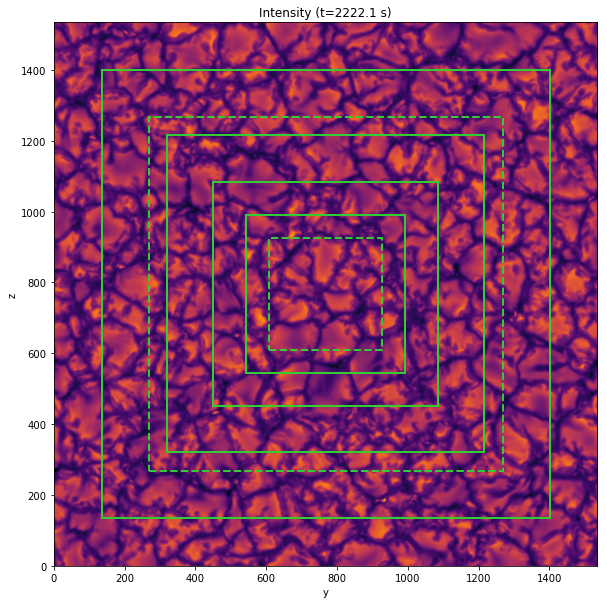

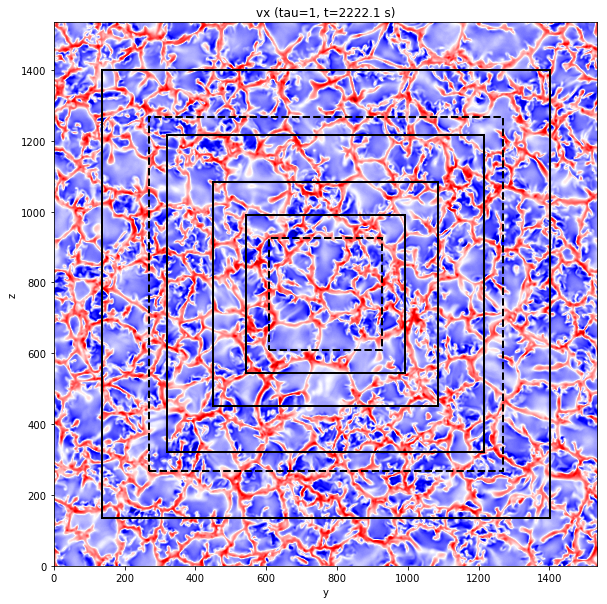

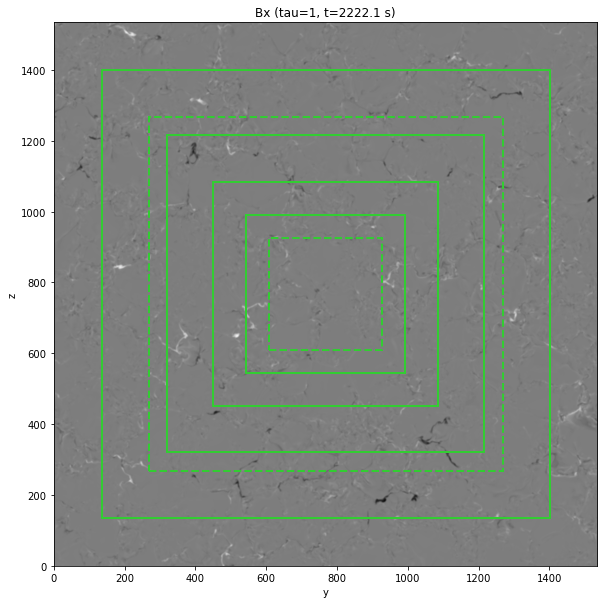

In [7]:
imparams = dict(origin='lower', interpolation='bicubic')
sequential = dict(**imparams, cmap='inferno')
diverging = dict(**imparams, cmap='seismic_r')
magnetogram = dict(**imparams, cmap='gray')

def add_boxes(ax, **kwargs):
    """Adds boxes to an axis"""
    # dashed lines: boxes containing 1e5, 1e6 pixels
    for i in (1, 10):
        ax.add_patch(make_box(i*1e5, **kwargs, ls='--'))
    # solid lines: boxes containing 2**n * 1e5 pixels
    for i in (2, 4, 8, 16):   
        ax.add_patch(make_box(i*1e5, **kwargs))


figsize = (10,10)
fig, ax = plt.subplots(figsize=figsize)
ax.imshow(intensity, **sequential)
add_boxes(ax, color='limegreen', lw=2)
#ax.axhline(zslice, c='limegreen')
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_title(f"Intensity (t={intensity.time:0.1f} s)")
fig.savefig('intensity.png')

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(tau_slice.vx, **diverging)
add_boxes(ax, color='k', lw=2)
#ax.axhline(zslice, c='limegreen')
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_title(f"vx (tau=1, t={tau_slice.time:0.1f} s)")
fig.savefig('vx.png')

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(tau_slice.Bx, **magnetogram)
add_boxes(ax, color='limegreen', lw=2)
#ax.axhline(zslice, c='limegreen')
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.set_title(f"Bx (tau=1, t={tau_slice.time:0.1f} s)")
fig.savefig('Bx.png')

## Plot vertical slice

In [8]:
xy_slice = muram.MuramXYSlice(dir2D, zslice, iteration)

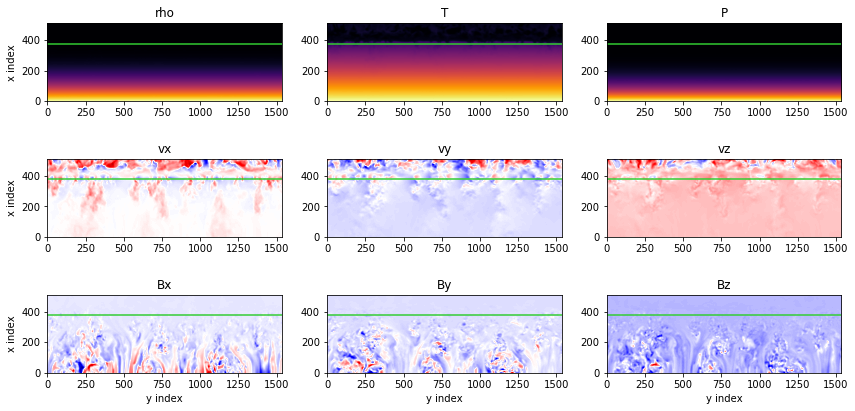

In [9]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12,6))

ax1.imshow(xy_slice.rho, **sequential)
ax1.set_title("rho")

#ax2.imshow(xy_slice.eps, **sequential)
#x2.set_title("eps")

ax2.imshow(xy_slice.T, **sequential)
ax2.set_title("T")

ax3.imshow(xy_slice.P, **sequential)
ax3.set_title("P")

ax4.imshow(xy_slice.vx, **diverging)
ax4.set_title("vx")

ax5.imshow(xy_slice.vy, **diverging)
ax5.set_title("vy")

ax6.imshow(xy_slice.vz, **diverging)
ax6.set_title("vz")

ax7.imshow(xy_slice.Bx, **diverging)
ax7.set_title("Bx")

ax8.imshow(xy_slice.By, **diverging)
ax8.set_title("By")

ax9.imshow(xy_slice.Bz, **diverging)
ax9.set_title("Bz")

for ax in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9):
    ax.axhline(xtau1, c='limegreen')

for ax in (ax7, ax8, ax9):
    ax.set_xlabel('y index')
    
for ax in (ax1, ax4, ax7):
    ax.set_ylabel('x index')
    
fig.tight_layout()
fig.savefig('xy_slice.pdf', bbox_inches='tight')

## Plot column of atmosphere

In [10]:
col = xy_slice.column(0)

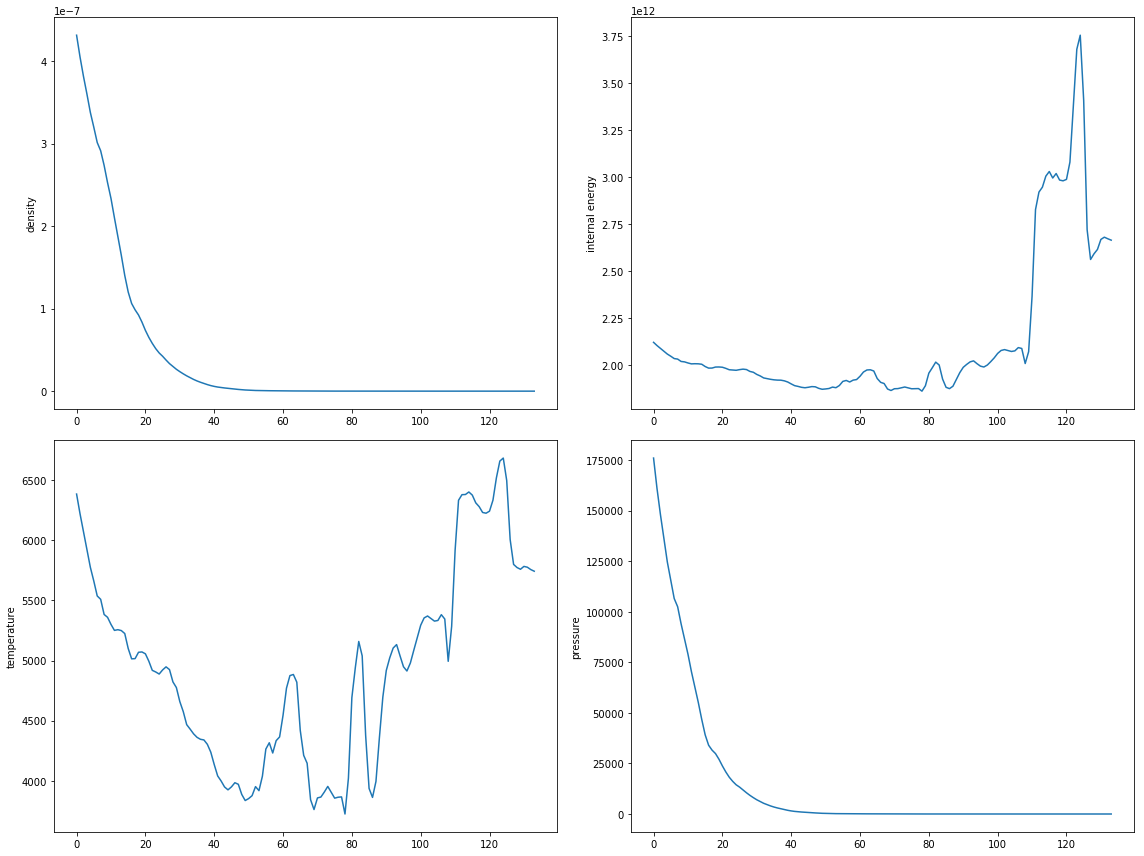

In [11]:
def plot_col(col):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    ax1.plot(col.rho[xtau1:])
    ax1.set_ylabel('density')
    ax2.plot(col.eint[xtau1:])
    ax2.set_ylabel('internal energy')
    ax3.plot(col.T[xtau1:])
    ax3.set_ylabel('temperature')
    ax4.plot(col.P[xtau1:])
    ax4.set_ylabel('pressure')
    fig.tight_layout()
    
plot_col(col)

## Compare approximate tau=1 height to real tau=1 level

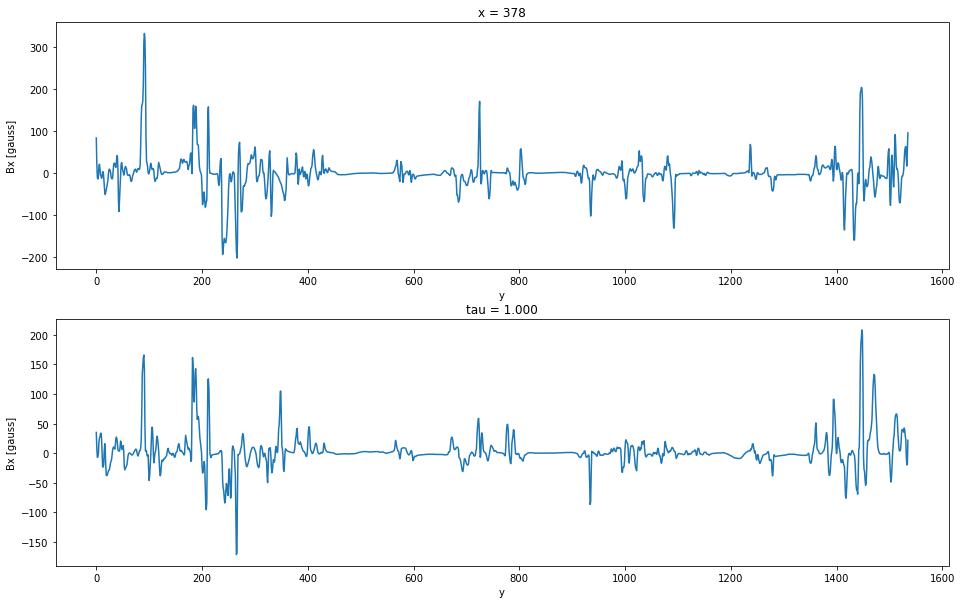

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
ax1.plot(xy_slice.Bx[xtau1, :])
ax1.set_xlabel("y")
ax1.set_ylabel("Bx [gauss]")
ax1.set_title(f"x = {xtau1}")

ax2.plot(tau_slice.Bx[:, zslice])
ax2.set_xlabel("y")
ax2.set_ylabel("Bx [gauss]")
ax2.set_title(f"tau = {tau_slice.ix}")
fig.savefig('Bz_xy_vs_tau1.pdf', bbox_inches='tight')

## Using/Validating MuramCube object

Below I load data into the MuramCube object and verify slices and columns derived from it from slices loaded from disk above.

In [13]:
xy_slice.shape

(10, 512, 1536)

In [14]:
# Size of data cube in GB (one variable)
1536 ** 2 * 512 * 4 / (1024**3)

4.5

In [15]:
# Size of slice in GB (10 variables)
10 * 1536 * 512 * 4 / (1024**3)

0.029296875

In [16]:
xy_slice.rho[0:10,1] # baseline data

MuramXYSlice([0.00026493, 0.00026316, 0.0002614 , 0.00025964, 0.00025789,
              0.00025615, 0.00025441, 0.00025268, 0.00025095, 0.00024923],
             dtype=float32)

In [17]:
# List of variables that are potentially written by MURaM
muram.MuramCube.varnames

('rho',
 'vx',
 'vy',
 'vz',
 'eint',
 'Bx',
 'By',
 'Bz',
 'sflx',
 'T',
 'P',
 'ne',
 'amb',
 'rhoi',
 'Q',
 'J',
 'S',
 'tau',
 'QxH',
 'QxCa',
 'QxMg',
 'QxCor',
 'QxChr',
 'Qres',
 'Qvis')

In [18]:
# Load a data cube
cube = muram.MuramCube(dir3D, iteration, 'rho')

In [19]:
cube[0:10,1,zslice] # should be same as above

memmap([0.00026493, 0.00026316, 0.0002614 , 0.00025964, 0.00025789,
        0.00025615, 0.00025441, 0.00025268, 0.00025095, 0.00024923],
       dtype=float32)

In [20]:
(cube[:,1,zslice] - xy_slice.rho[:,1]).sum() # should be zero

MuramXYSlice(0., dtype=float32)

## Using validating MuramSnap object

In [21]:
snap = muram.MuramSnap(dir3D, iteration)

In [22]:
# Variables that are available from this snapshot
snap.available

['rho',
 'vx',
 'vy',
 'vz',
 'eint',
 'Bx',
 'By',
 'Bz',
 'T',
 'P',
 'Q',
 'tau',
 'Qres',
 'Qvis']

In [23]:
snap.rho.shape

(512, 1536, 1536)

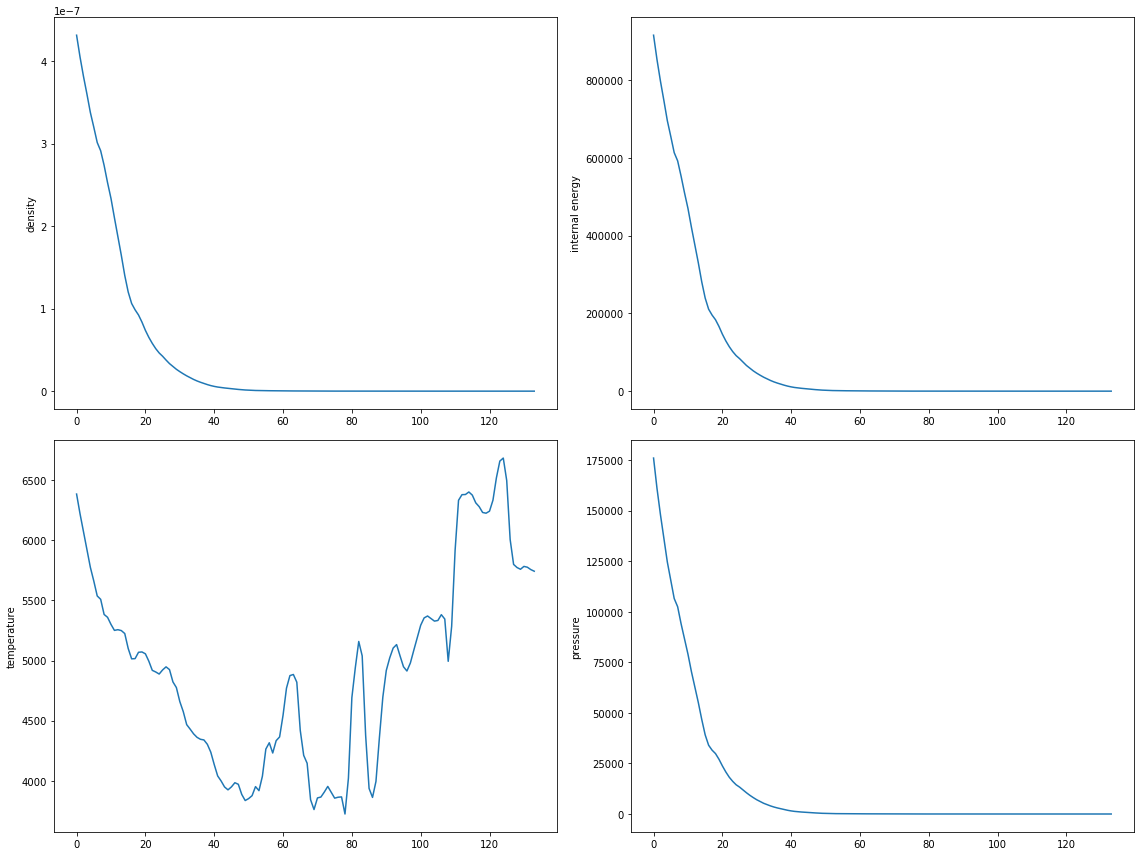

In [24]:
col2 = snap.column(0, zslice)
plot_col(col2)

In [25]:
(col.rho - col2.rho).sum() # should be 0

MuramXYSlice(0., dtype=float32)

## Initializing slices from MuramSnap

**Note/TODO**: The below worked on my laptop where I only had a few variables available.  On cheyenne, where all variable are available, this runs out of memory.  That is unexpected and needs to be fixed.

In [26]:
#xy_slice2 = snap.slice('xy', zslice)

In [27]:
#(xy_slice.rho - xy_slice2.rho).sum() # should be 0

In [28]:
#yz_slice = snap.slice('yz', 0)
#yz_slice

In [29]:
#xz_slice = snap.slice('xz', 0)
#xz_slice

In [30]:
#tau_slice2 = snap.slice('tau', 1)